## Requirements

In [1]:
!pip install transformers
!pip install datasets
!pip install pytorch_metric_learning
!pip install opendatasets
!pip install pydub
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.3/109.3 kB 3.2 MB/s eta 0:00:00


In [2]:
import torch
from transformers import AutoProcessor, Wav2Vec2Model
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from pytorch_metric_learning.losses import ContrastiveLoss
from time import time
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import os
from pydub import AudioSegment
import opendatasets as od
import pandas as pd
import gc
import random
import pickle
import gdown

## Load Files

In [3]:
url = "https://drive.google.com/file/d/1klayW8tzpkmhS6n6Zb3ljvDG40SakMjR/view?usp=sharing"
output = "audios_dataset.npy"
gdown.download(url, output, quiet=False, fuzzy=True)

url = "https://drive.google.com/file/d/1-1HvdclgtF-geqbVJC8sOxJ0Q2oLS6ex/view?usp=share_link"
output = "keywords_dataset.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1klayW8tzpkmhS6n6Zb3ljvDG40SakMjR
To: /kaggle/working/audios_dataset.npy
100%|██████████| 4.79G/4.79G [00:25<00:00, 184MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-1HvdclgtF-geqbVJC8sOxJ0Q2oLS6ex
To: /kaggle/working/keywords_dataset.pkl
100%|██████████| 109k/109k [00:00<00:00, 38.7MB/s]


'keywords_dataset.pkl'

In [7]:
url = "https://drive.google.com/file/d/1A71382-jde_gtaNwwgXd_U6S4XZg6_cp/view?usp=share_link"
output = "text_embeddings.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

url = "https://drive.google.com/file/d/1xn7FSK8GkEh7N4lqsmIf8e07qHjTau9I/view?usp=share_link"
output = "audio_embeddings.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1A71382-jde_gtaNwwgXd_U6S4XZg6_cp
To: /kaggle/working/text_embeddings.pkl
100%|██████████| 10.2M/10.2M [00:00<00:00, 12.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xn7FSK8GkEh7N4lqsmIf8e07qHjTau9I
To: /kaggle/working/audio_embeddings.pkl
100%|██████████| 10.2M/10.2M [00:00<00:00, 37.4MB/s]


'audio_embeddings.pkl'

## Load Models

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# Loading data
with open('keywords_dataset.pkl', 'rb') as f:
    keywords_dataset = pickle.load(f)
audios_dataset = np.load('audios_dataset.npy', allow_pickle=True)
print(len(keywords_dataset), len(audios_dataset))

3000 3000


In [ ]:
audio_processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
audio_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_model = AutoModel.from_pretrained("bert-base-uncased").to(device)

## Preparing Data

In [ ]:
text_model = text_model.to('cuda:1')
text_embeddings = []
for text_idx in tqdm(range(len(keywords_dataset))):
    if text_idx % 100 == 0:
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    text = keywords_dataset[text_idx]
    inputs = tokenizer(text, return_tensors="pt").to('cuda:1')
    outputs = text_model(**inputs)
    embeddings = outputs.last_hidden_state.squeeze(0)
    pooled_embeddings = embeddings.mean(dim=0)
    text_embeddings.append(pooled_embeddings)
len(text_embeddings)

In [ ]:
audio_embeddings = []
for audio_idx in tqdm(range(len(audios_dataset))):
    if audio_idx % 100 == 0:
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    audio = torch.from_numpy(audios_dataset[audio_idx])
    inputs = audio_processor(audio, sampling_rate=16000, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = audio_model(**inputs)
    last_hidden_states = outputs.last_hidden_state.squeeze(0)
    embeddings = last_hidden_states.mean(dim=0)
    audio_embeddings.append(embeddings)
len(audio_embeddings)

In [ ]:
import pickle as pkl

with open('text_embeddings.pkl', 'wb') as f:
    pkl.dump(text_embeddings, f)

with open('audio_embeddings.pkl', 'wb') as f:
    pkl.dump(audio_embeddings, f)

In [397]:
import pickle as pkl

with open('text_embeddings.pkl', 'rb') as f:
    text_embeddings = pkl.load(f)

with open('audio_embeddings.pkl', 'rb') as f:
    audio_embeddings = pkl.load(f)

In [398]:
class MMDataSet(Dataset):
    def __init__(self, text_embeddings, audio_embeddings):
        self.text_embedings = text_embeddings
        self.audio_embeddings = audio_embeddings
        
    def __len__(self):
        return len(self.text_embedings)

    def __getitem__(self, i):
        return self.text_embedings[i], self.audio_embeddings[i]

In [399]:
text_embedding_train, text_embedding_test, audio_embedding_train, audio_embedding_test = train_test_split(text_embeddings, audio_embeddings, test_size=0.15, random_state=42)
train_loader = DataLoader(dataset= MMDataSet(text_embedding_train, audio_embedding_train), batch_size=64, shuffle=True)
test_loader = DataLoader(dataset= MMDataSet(text_embedding_test, audio_embedding_test), batch_size=64, shuffle=False)

## Model

In [400]:
class JointNN(nn.Module):
    def __init__(self, in_features):
        super(JointNN, self).__init__()
        self.text_seq = nn.Sequential(
            nn.Linear(in_features, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features),
        )
        self.audio_seq = nn.Sequential(
            nn.Linear(in_features, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features),
        )

    def forward(self, x_text, x_audio):
        x1 = self.text_seq(x_text)
        x2 = self.audio_seq(x_audio)
        return x1, x2

## Loss

In [401]:
l1_loss = nn.L1Loss()
def mse_csim_loss(pred, target, batch_size=8):
    loss = torch.zeros(batch_size, batch_size)
    for i in range(batch_size):
        for j in range(batch_size):
            if i == j:
                loss[i, j] = batch_size * l1_loss(pred[i, :], target[j, :])
            else:
                loss[i, j] = F.cosine_similarity(pred[i, :], target[j, :], 0) + 1
    return loss.sum()

In [402]:
from pytorch_metric_learning.losses import ContrastiveLoss
criterion = ContrastiveLoss()

In [403]:
l1_loss = nn.L1Loss()

In [404]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size=32, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [405]:
class CustomContrastiveLoss(nn.Module):
   """
   Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
   """
   def __init__(self, temperature=0.5):
       super().__init__()
       self.temperature = temperature
       

   def calc_similarity_batch(self, a, b):
       representations = torch.cat([a, b], dim=0)
       return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

   def forward(self, proj_1, proj_2, batch_size):
       """
       proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
       where corresponding indices are pairs
       z_i, z_j in the SimCLR paper
       """
       mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()
       batch_size = proj_1.shape[0]
       z_i = F.normalize(proj_1, p=2, dim=1)
       z_j = F.normalize(proj_2, p=2, dim=1)

       similarity_matrix = self.calc_similarity_batch(z_i, z_j)

       sim_ij = torch.diag(similarity_matrix, batch_size)
       sim_ji = torch.diag(similarity_matrix, -batch_size)

       positives = torch.cat([sim_ij, sim_ji], dim=0)

       nominator = torch.exp(positives / self.temperature)

       denominator = device_as(mask, similarity_matrix) * torch.exp(similarity_matrix / self.temperature)

       all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
       loss = torch.sum(all_losses) / (2 * batch_size)
       return loss

def device_as(t1, t2):
   """
   Moves t1 to the device of t2
   """
   return t1.to(t2.device)

## Training Process

In [406]:
model = JointNN(768).to(device)
criterion = CustomContrastiveLoss(0.7)
learning_rate = 2e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [407]:
def eval_epoch(model: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader, test_mode=False):
    eval_loss = 0
    i = 0 

    with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (text_emb, audio_emb) in pbar:
            text_emb = text_emb.to(device)
            audio_emb = audio_emb.to(device)
            text_final_emb, audio_final_emb = model(text_emb, audio_emb)

#             batch_size = text_emb.shape[0]
#             labels = torch.zeros(batch_size * batch_size)
#             text_embs_series = torch.zeros(batch_size * batch_size, text_final_emb.shape[1])
#             audio_embs_series = torch.zeros(batch_size * batch_size, text_final_emb.shape[1])

#             for i in range(batch_size):
#               for j in range(batch_size):
#                 text_embs_series[(batch_size * i) + j] = text_final_emb[i,:]
#                 audio_embs_series[(batch_size * i) + j] = audio_final_emb[j,:]
#                 if i == j:
#                   labels[(batch_size * i) + j] = 1                    

            loss = criterion(text_final_emb, audio_final_emb, text_emb.shape[0])

            eval_loss += loss.item()

            discription = 'Validation' if not test_mode else 'Test'
            pbar.set_description(f'{discription} Loss: {loss.item():.4f}')
    return eval_loss

In [408]:
num_epochs = 25

train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    start_time = time()

    train_loss, val_loss = 0, 0
    epoch_all = 0
    epoch_true = 0
    i = 0

    model.train()
    
    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (text_emb, audio_emb) in pbar:    
            text_emb = text_emb.to(device)
            audio_emb = audio_emb.to(device)

            
            text_final_emb, audio_final_emb = model(text_emb, audio_emb)
            
#             batch_size = text_emb.shape[0]
#             labels = torch.zeros(batch_size * batch_size)
#             text_embs_series = torch.zeros(batch_size * batch_size, text_final_emb.shape[1])
#             audio_embs_series = torch.zeros(batch_size * batch_size, text_final_emb.shape[1])

#             for i in range(batch_size):
#                 for j in range(batch_size):
#                     text_embs_series[(batch_size * i) + j] = text_final_emb[i,:]
#                     audio_embs_series[(batch_size * i) + j] = audio_final_emb[j,:]
#                     if i == j:
#                         labels[(batch_size * i) + j] = 1                

            loss = criterion(text_final_emb, audio_final_emb, text_emb.shape[0])
            
            
            train_loss += loss.item()

            pbar.set_description(f'Loss: {loss.item():.4f}')

            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

  
    model.eval()
    
    val_loss = eval_epoch(model, criterion, test_loader)
    
    train_loss /= len(train_loader.dataset)
    val_loss /= len(test_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    
    end_time = time()
    
    print(f'Epoch {epoch + 1} finished in {end_time - start_time:.2f}s')

    print(f"[Epoch {epoch + 1}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}")

Validation Loss: 1.2827: 100%|██████████| 8/8 [00:00<00:00, 175.03it/s]


Epoch 1 finished in 0.75s
[Epoch 1]	Train Loss: 0.0783	Validation Loss: 0.0820


Validation Loss: 1.0857: 100%|██████████| 8/8 [00:00<00:00, 176.25it/s]


Epoch 2 finished in 0.70s
[Epoch 2]	Train Loss: 0.0759	Validation Loss: 0.0778


Validation Loss: 1.0691: 100%|██████████| 8/8 [00:00<00:00, 159.54it/s]


Epoch 3 finished in 0.73s
[Epoch 3]	Train Loss: 0.0757	Validation Loss: 0.0776


Validation Loss: 1.0674: 100%|██████████| 8/8 [00:00<00:00, 171.60it/s]


Epoch 4 finished in 0.76s
[Epoch 4]	Train Loss: 0.0755	Validation Loss: 0.0774


Validation Loss: 1.0589: 100%|██████████| 8/8 [00:00<00:00, 169.77it/s]


Epoch 5 finished in 0.69s
[Epoch 5]	Train Loss: 0.0752	Validation Loss: 0.0771


Validation Loss: 1.0552: 100%|██████████| 8/8 [00:00<00:00, 174.28it/s]


Epoch 6 finished in 0.68s
[Epoch 6]	Train Loss: 0.0748	Validation Loss: 0.0765


Validation Loss: 1.0412: 100%|██████████| 8/8 [00:00<00:00, 165.80it/s]


Epoch 7 finished in 0.70s
[Epoch 7]	Train Loss: 0.0741	Validation Loss: 0.0756


Validation Loss: 1.0377: 100%|██████████| 8/8 [00:00<00:00, 146.65it/s]


Epoch 8 finished in 0.69s
[Epoch 8]	Train Loss: 0.0731	Validation Loss: 0.0750


Validation Loss: 1.0566: 100%|██████████| 8/8 [00:00<00:00, 163.82it/s]


Epoch 9 finished in 0.68s
[Epoch 9]	Train Loss: 0.0724	Validation Loss: 0.0748


Validation Loss: 1.0791: 100%|██████████| 8/8 [00:00<00:00, 173.80it/s]


Epoch 10 finished in 0.70s
[Epoch 10]	Train Loss: 0.0718	Validation Loss: 0.0747


Validation Loss: 1.0701: 100%|██████████| 8/8 [00:00<00:00, 133.56it/s]


Epoch 11 finished in 0.85s
[Epoch 11]	Train Loss: 0.0713	Validation Loss: 0.0745


Validation Loss: 1.1357: 100%|██████████| 8/8 [00:00<00:00, 170.42it/s]


Epoch 12 finished in 0.70s
[Epoch 12]	Train Loss: 0.0708	Validation Loss: 0.0749


Validation Loss: 1.1064: 100%|██████████| 8/8 [00:00<00:00, 176.82it/s]


Epoch 13 finished in 0.70s
[Epoch 13]	Train Loss: 0.0704	Validation Loss: 0.0745


Validation Loss: 1.1326: 100%|██████████| 8/8 [00:00<00:00, 173.86it/s]


Epoch 14 finished in 0.68s
[Epoch 14]	Train Loss: 0.0700	Validation Loss: 0.0745


Validation Loss: 1.1269: 100%|██████████| 8/8 [00:00<00:00, 176.49it/s]


Epoch 15 finished in 0.70s
[Epoch 15]	Train Loss: 0.0696	Validation Loss: 0.0742


Validation Loss: 1.1300: 100%|██████████| 8/8 [00:00<00:00, 174.82it/s]


Epoch 16 finished in 0.68s
[Epoch 16]	Train Loss: 0.0692	Validation Loss: 0.0742


Validation Loss: 1.1468: 100%|██████████| 8/8 [00:00<00:00, 172.69it/s]


Epoch 17 finished in 0.69s
[Epoch 17]	Train Loss: 0.0688	Validation Loss: 0.0741


Validation Loss: 1.1368: 100%|██████████| 8/8 [00:00<00:00, 171.14it/s]


Epoch 18 finished in 0.70s
[Epoch 18]	Train Loss: 0.0684	Validation Loss: 0.0740


Validation Loss: 1.1860: 100%|██████████| 8/8 [00:00<00:00, 173.75it/s]


Epoch 19 finished in 0.68s
[Epoch 19]	Train Loss: 0.0681	Validation Loss: 0.0741


Validation Loss: 1.1789: 100%|██████████| 8/8 [00:00<00:00, 165.85it/s]


Epoch 20 finished in 0.70s
[Epoch 20]	Train Loss: 0.0677	Validation Loss: 0.0740


Validation Loss: 1.2026: 100%|██████████| 8/8 [00:00<00:00, 176.10it/s]


Epoch 21 finished in 0.68s
[Epoch 21]	Train Loss: 0.0674	Validation Loss: 0.0741


Validation Loss: 1.2113: 100%|██████████| 8/8 [00:00<00:00, 173.29it/s]


Epoch 22 finished in 0.81s
[Epoch 22]	Train Loss: 0.0671	Validation Loss: 0.0740


Validation Loss: 1.2087: 100%|██████████| 8/8 [00:00<00:00, 173.63it/s]


Epoch 23 finished in 0.70s
[Epoch 23]	Train Loss: 0.0667	Validation Loss: 0.0739


Validation Loss: 1.1922: 100%|██████████| 8/8 [00:00<00:00, 180.57it/s]


Epoch 24 finished in 0.68s
[Epoch 24]	Train Loss: 0.0665	Validation Loss: 0.0739


Validation Loss: 1.2082: 100%|██████████| 8/8 [00:00<00:00, 173.40it/s]

Epoch 25 finished in 0.70s
[Epoch 25]	Train Loss: 0.0661	Validation Loss: 0.0739


### Plot Loss

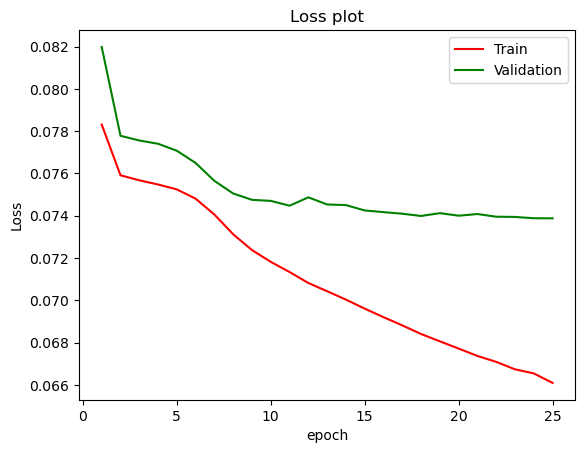

In [409]:
ls_epoch = [_ + 1 for _ in range(num_epochs)]
plt.plot(ls_epoch, train_loss_arr, color='r', label='Train')
plt.plot(ls_epoch, val_loss_arr, color='g', label='Validation')
plt.title('Loss plot')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()  

### Save & Load Model

In [410]:
PATH = "multimodal_model.pt"
torch.save(model, PATH)

In [411]:
# Load
# PATH = "multimodal_model.pt"
# model = torch.load(PATH)
# model.eval()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

In [412]:
import gc
gc.collect()

3592

In [413]:
dataset = load_dataset("asapp/slue", "voxpopuli")
selected_dataset = dataset['test'].shuffle(0).select(range(20))
texts = selected_dataset['normalized_text']
audios = [x["array"] for x in selected_dataset['audio']]

  0%|          | 0/3 [00:00<?, ?it/s]

## Wrapper Final Model

In [414]:
class SimilarityModel:
    def __init__(self, path_to_multimodal_model, sampling_rate=16000, threshold=0.5):
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      self.audio_processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
      self.audio_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(self.device)
      self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
      self.text_model = AutoModel.from_pretrained("bert-base-uncased").to(self.device)
      self.threshold = threshold
      self.nn_model = torch.load(path_to_multimodal_model)
      self.nn_model.eval()
      self.nn_model = self.nn_model.to(self.device)
      self.sampling_rate = sampling_rate

    def cosine_similarity(self, embedding1, embedding2):
      dim = 1
      embedding1 = F.normalize(embedding1, p=2, dim=dim)
      embedding2 = F.normalize(embedding2, p=2, dim=dim)

      dot_product = torch.sum(embedding1 * embedding2, dim=dim)

      magnitude1 = torch.norm(embedding1, p=2, dim=dim)
      magnitude2 = torch.norm(embedding2, p=2, dim=dim)

      cosine_sim = dot_product / (magnitude1 * magnitude2)

      return cosine_sim

    def predict(self, audios, texts, threshold=None, is_query=False):
      audio_embs = []
      for audio in tqdm(audios):
        inputs = self.audio_processor(audio, sampling_rate=self.sampling_rate, return_tensors="pt", padding=True).to(device)
        outputs = self.audio_model(**inputs)
        last_hidden_states = outputs.last_hidden_state.squeeze(0)
        audio_embedding = last_hidden_states.mean(dim=0)
        audio_embs.append(audio_embedding)

      text_embs = []
      for text in texts:
        inputs = self.tokenizer(text, return_tensors="pt").to(device)
        outputs = self.text_model(**inputs)
        embedding = outputs.last_hidden_state.squeeze(0)
        text_embedding = embedding.mean(dim=0)
        text_embs.append(text_embedding)
      if is_query:
        item = text_embs[0]
        for i in range(len(audios) - 1):
          text_embs.append(item.clone())


      audio_embedding = torch.stack(audio_embs)
      text_embedding = torch.stack(text_embs)
      text_embedding = text_embedding.to(self.device)
      audio_embedding = audio_embedding.to(self.device)

      text_final_emb, audio_final_emb = self.nn_model(text_embedding, audio_embedding)
      cosine_similarity = self.cosine_similarity(text_final_emb, audio_final_emb)
      print(cosine_similarity)

      final_threshold = threshold if threshold else self.threshold

      return (cosine_similarity >= final_threshold).int()

    def retrieve_relevant_audios(self, audios, query, threshold=None):
      return self.predict(audios, [query], is_query=True, threshold=threshold)

In [415]:
PATH = "multimodal_model.pt"

final_model = SimilarityModel(PATH)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_r

## Test and Evaluation

In [416]:
final_model.predict(audios[2:8], texts[2:8])

100%|██████████| 6/6 [00:00<00:00, 10.65it/s]


tensor([0.8103, 0.8560, 0.8784, 0.4848, 0.8143, 0.8661], device='cuda:0',
       grad_fn=<DivBackward0>)


tensor([1, 1, 1, 0, 1, 1], device='cuda:0', dtype=torch.int32)

In [417]:
total_num = 20
text_embedding = text_embedding_test[0].to(device)
audio_embeddings = torch.stack([audio_embedding_test[i].to(device) for i in range(total_num)])
cosine_similarity_list = []

for i in range(total_num):
    text_final_emb, audio_final_emb = final_model.nn_model(text_embedding.unsqueeze(0), audio_embeddings[i].unsqueeze(0))
    cosine_similarity = final_model.cosine_similarity(text_final_emb, audio_final_emb)
    cosine_similarity_list.append(cosine_similarity.item())
cosine_similarity_list

[0.7175573110580444,
 -0.6256155371665955,
 0.6116508841514587,
 0.5225169062614441,
 -0.13548485934734344,
 -0.7701019048690796,
 0.6144395470619202,
 -0.6963900923728943,
 0.36632323265075684,
 -0.16621123254299164,
 0.6622025966644287,
 0.2507905960083008,
 -0.5211548209190369,
 -0.6872664093971252,
 0.2049078345298767,
 -0.27444276213645935,
 0.5155132412910461,
 0.0661877989768982,
 -0.09363400191068649,
 0.6025703549385071]

In [418]:
final_model.retrieve_relevant_audios(audios[10:14], texts[10])

100%|██████████| 4/4 [00:00<00:00, 20.16it/s]


tensor([0.2576, 0.6519, 0.8484, 0.8357], device='cuda:0',
       grad_fn=<DivBackward0>)


tensor([0, 1, 1, 1], device='cuda:0', dtype=torch.int32)

## Finding best hyper parameteres

In [419]:
# find best hyperparameter

size = len(audios)
labels = []
text_series = []
audio_series = []

for i in range(size):
  for j in range(size):
    text_series.append(texts[i])
    audio_series.append(audios[j])
    labels.append(1 if i == j else 0)              

In [420]:
def accuracy_of_model(model, audios, texts, labels, threshold):
  result = model.predict(audios, texts, threshold=threshold)
  accuracy = accuracy_score(result.detach().cpu(), labels)
  return accuracy

In [421]:
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

95

In [422]:
zipped_lists = list(zip(audio_series, text_series, labels))

n = 10
sampled_tuples = random.sample(zipped_lists, n)

# unzip the sampled tuples into separate lists
audios_test, texts_test, labels_test = zip(*sampled_tuples)

In [423]:
threshold_list = [0.05 * i for i in range(4,18)]
best_accuracy = 0
best_threshold = 0
for threshold in threshold_list:
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    accuracy = accuracy_of_model(final_model, audios_test, texts_test, labels_test, threshold)
    print(f"Accuracy with threshold {threshold:.2f} = {accuracy * 100:.2f}%")
    if accuracy > best_accuracy:
        best_threshold = threshold
        best_accuracy = accuracy
    gc.collect()

print(f"Best threshold is {best_threshold:.2f}")
print(f"Best accuracy is {best_accuracy:.2f}")

100%|██████████| 10/10 [00:00<00:00, 12.82it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.20 = 20.00%


100%|██████████| 10/10 [00:00<00:00, 13.99it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.25 = 20.00%


100%|██████████| 10/10 [00:00<00:00, 14.10it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.30 = 20.00%


100%|██████████| 10/10 [00:00<00:00, 14.15it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.35 = 20.00%


100%|██████████| 10/10 [00:00<00:00, 13.98it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.40 = 20.00%


100%|██████████| 10/10 [00:00<00:00, 13.09it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.45 = 20.00%


100%|██████████| 10/10 [00:00<00:00, 14.01it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.50 = 20.00%


100%|██████████| 10/10 [00:00<00:00, 13.98it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.55 = 20.00%


100%|██████████| 10/10 [00:00<00:00, 13.90it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.60 = 20.00%


100%|██████████| 10/10 [00:00<00:00, 13.75it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.65 = 20.00%


100%|██████████| 10/10 [00:00<00:00, 13.90it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.70 = 30.00%


100%|██████████| 10/10 [00:00<00:00, 13.72it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.75 = 60.00%


100%|██████████| 10/10 [00:00<00:00, 12.68it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.80 = 70.00%


100%|██████████| 10/10 [00:00<00:00, 13.92it/s]


tensor([0.6574, 0.8424, 0.8530, 0.8562, 0.7607, 0.7393, 0.8328, 0.7265, 0.1282,
        0.7248], device='cuda:0', grad_fn=<DivBackward0>)
Accuracy with threshold 0.85 = 90.00%
Best threshold is 0.85
Best accuracy is 0.90


In [424]:
PATH = "multimodal_model.pt"
best_model = SimilarityModel(PATH, threshold=best_threshold)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_r

In [425]:
PATH = "final_relevant_model_v2.pt"

# Save
torch.save(best_model, PATH)

In [ ]:
# Load
PATH = "final_relevant_model.pt"
best_model = torch.load(PATH)
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

In [426]:
from IPython.display import FileLink
FileLink(r'final_relevant_model_v2.pt')

/kaggle/working/final_relevant_model_v2.pt

In [427]:
from IPython.display import FileLink
FileLink(r'multimodal_model.pt')

/kaggle/working/multimodal_model.pt